In [67]:
import copy
import numpy as np
import matplotlib.pyplot as p
import astropy.units as u
import funcs
import emcee
import corner
from scipy import optimize

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
lc = np.genfromtxt('Lightcurves/KIC818_clean_eclonly_llconly.txt')
print(lc[0,0])

188.870937209


In [75]:
# KIC008180020 (incorporating some fit values)
#pp = 279.284861
#pb = 5.8031267986
#ap = ((pp/365.25)**2 * (0.9+0.3588) )**(1./3.)
#ab = ((pb/365.25)**2 * (0.9+0.3588) )**(1./3.)
time = lc[:,0]+2455000.
flux = lc[:,1]
err = lc[:,2]
time.shape

rv_t = np.array([1443.82210,1446.92356,1457.82103,1459.79856,1460.90038,1461.91270]) + 2455000
rv_val = np.array([-74.9556,-33.3380,-51.6407,-38.7746,-65.6135,-81.6842])
rv_err = np.array([1.180,0.341,0.167,0.182,0.122,0.176])

pb = 5.8031283
q = 0.226533
ab_fit = 15.863458*u.Rsun.to('AU')
totmass = ab_fit**3 / (pb/365.25)**2
print(totmass)
m1 = totmass/(q+1)
m2 = q*m1
print(m1)
print(m2)
ab = ( (m1+m2) * (pb/365.25)**2 )**(1./3.)
eb = 0.024462
wb = np.deg2rad(298.272222)
ib = np.deg2rad(88.591098)
fb = np.mod(np.pi/2. - wb,2*np.pi)
sbratio = 0.030820
r1ova = 0.092913
r2ova = 0.020545
f2ovf1 = sbratio * r2ova**2/r1ova**2
rvoffset = -56.243627

#1/(1/q+1)*ab is what we fit for


ap = 0.90365113427
#eb = 0.0195877256146
#wb = 1.16498521814
#ib = 1.60020721501
fp = 4.00934731719
ip = 1.57046348719
Wp = -0.00304280263608
ep = 0.207252008768
wp = 0.457360228291

#ab = 0.06823912797419374


cb = funcs.CBSystem(m1 = m1,f1 = 1.,m2 = m2,f2 = f2ovf1,
                    ab = ab,r1 = r1ova*ab,r2 = r2ova*ab,
                    eb = eb,ib = ib,wb = wb,
                    fb = fb,
                    mp = 0.0000001 * u.Mjup.to('Msun'),ap = ap,rp = 1.0 * u.Rjupiter.to('au'),
                    ep = ep,
                    ip = ip,wp = wp,fp = fp,
                    Wp = Wp,
                    t0 = 2455189.620003,
                    ld11 = 0.341355, ld21 = 0., ld12 = 0.405423, ld22 = 0.)

#from a (not perfect, but good for the binary lightcurve) full fit
#cb.eb = 0.0195056425515
#cb.fb = 2.10576478186
#cb.wb = 1.19539235839
#cb.ab = 0.0666172357858
#totalmass = 1.1711621943
#massratio = 0.405096097199
#massratio = 0.5
#cb.m2 = totalmass / (1 + 1./massratio)
#cb.m1 = totalmass / (1 + massratio)

cb.t0 -= 2455000
rv_t -= 2455000
time -= 2455000

ab0 = cb.ab
mb0 = cb.m1 + cb.m2
p_p0 = (cb.ap**3/(cb.m1+cb.m2))**(1./2.)*365.25 #in days
fb_wb0 = cb.fb + cb.wb
p_b0 = (cb.ab**3/(cb.m1+cb.m2))**(1./2.)*365.25 #in days
fp_wp0 = cb.fp + cb.wp

print((cb.ab**3/(cb.m1+cb.m2))**(1./2.)*365.25)
print(p_p0)
print(p_b0)
print(cb.m2)
timing_precision = 30./86400./365.25 * (2*np.pi)  #in years/2pi
t = time

1.5905212201056647
1.2967618646262795
0.293759355479385
5.803128300000003
248.7835655805022
5.803128300000003
0.293759355479385


In [80]:
f_pl, v_pl = funcs.pd_cb(cb, times=t)
tmp = cb.rp
cb.rp = 0.0
f_nopl, v_nopl = funcs.pd_cb(cb, times=t)
cb.rp = tmp
f_ref = f_pl / f_nopl

<IPython.core.display.Javascript object>


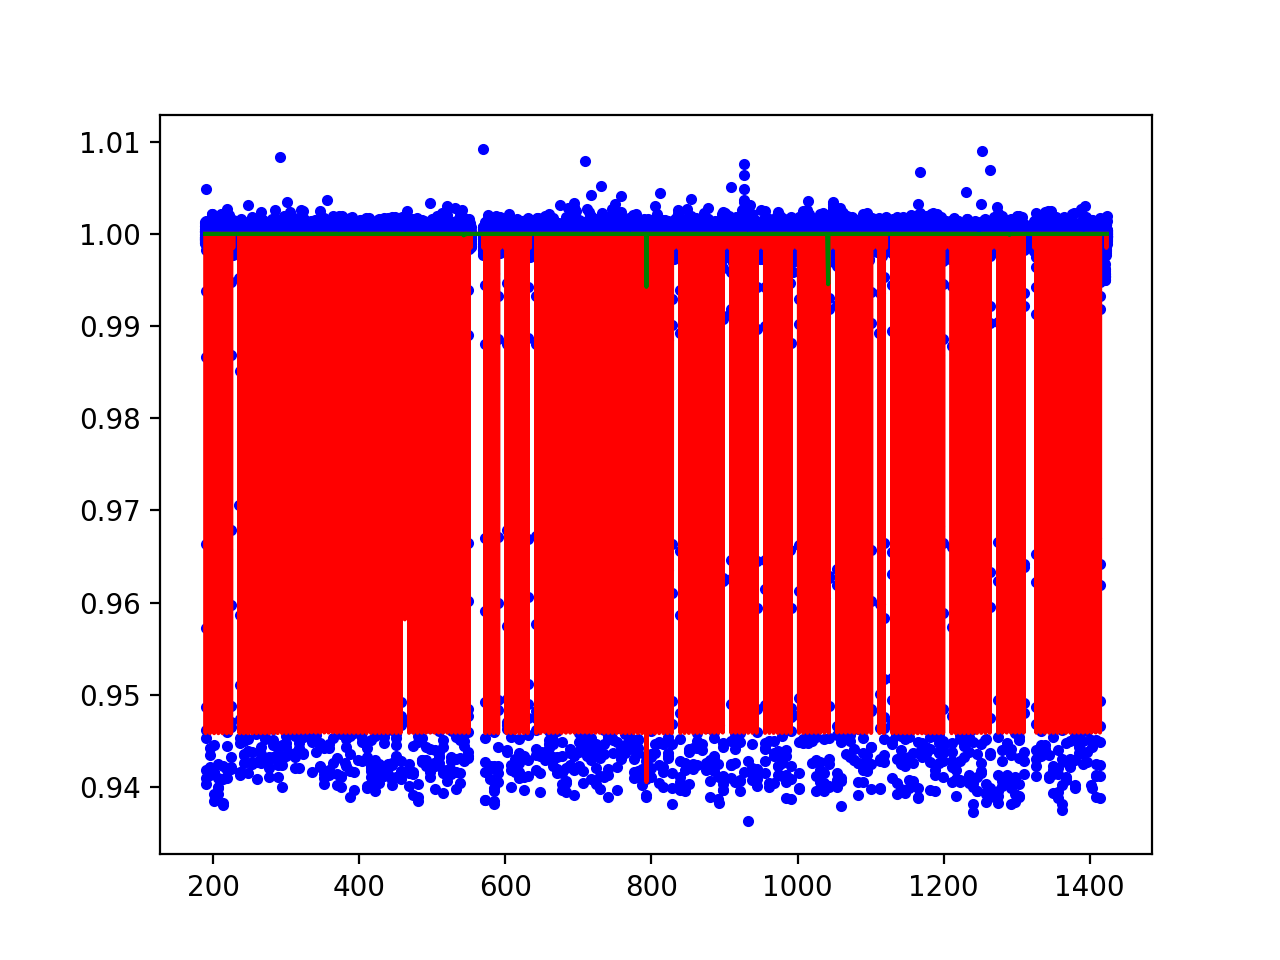

<IPython.core.display.Javascript object>


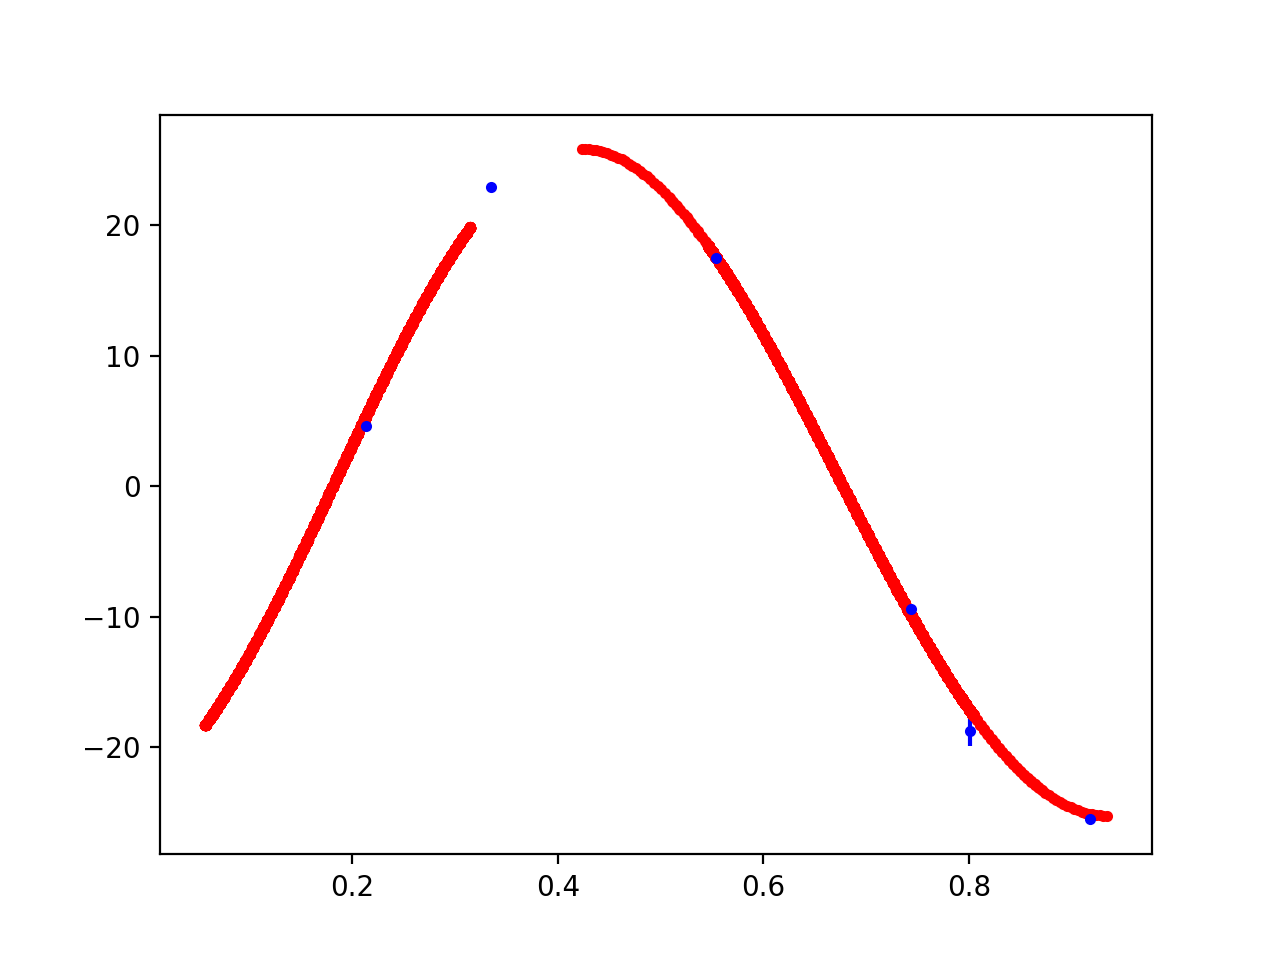

<Container object of 3 artists>

In [81]:
p.figure()
p.plot(time,flux,'b.')
p.plot(t,f_pl,'r-')
p.plot(t,f_ref,'g-')

phaset = np.mod(t,p_b0)/p_b0
rv_phase = np.mod(rv_t,p_b0)/p_b0
p.figure()
p.plot(phaset,(v_pl*1731.46),'r.')
p.errorbar(rv_phase,rv_val-rvoffset,yerr=rv_err,fmt='b.')



In [428]:
def rvfitfunc(par,*args):
    rv_t,rv_val,rv_err,cb,p_b0 = args

 #   cb_fit = funcs.CBSystem(m1 = cb.m1,f1 = cb.f1,m2 = cb.m2,f2 = cb.f2,
 #                   ab = cb.ab,r1 = cb.r1,r2 = cb.r2,
 #                   eb = cb.eb,ib = cb.ib,wb = cb.wb,
 #                   fb = cb.fb,
 #                   mp = cb.mp,ap = cb.ap,rp = cb.rp,
 ##                   ep = cb.ep,
 #                   ip = cb.ip,wp = cb.wp,fp = cb.fp,
 #                   Wp = cb.Wp,
 #                   t0 = cb.t0,
 #                   ld11 = cb.ld11, ld21 = cb.ld21, ld12 = cb.ld12, ld22 = cb.ld22)

    massratio, rvoffset = par
    cb.m2 = cb.m1 * massratio

    #cb.fp = np.mod(fp,2*np.pi)
    #cb.fb = np.mod(fb,2*np.pi)
    #cb.m2 = totalmass / (1 + 1./massratio)
    #cb.m1 = totalmass / (1 + massratio)
    #cb.ap = ( (cb.m1+cb.m2) * (p_p/365.25)**2 )**(1./3.)
    cb.ab = ( (cb.m1+cb.m2) * (p_b0/365.25)**2 )**(1./3.)
    
    if (massratio < 0.1) or (np.abs(rvoffset) > 100.):
        return np.ones(len(rv_t))*1e8
    #if (cb.ep < 0.) or (cb.eb < 0.) or (cb.ep >0.9) or (cb.eb >0.9):
    #    return np.ones(len(rv_t))*1e8    
    
    flux_model, vel_model = funcs.pd_cb(cb, times=rv_t)
    rv_model = vel_model/0.001
    return (rv_val-rvoffset-rv_model)/rv_err


In [429]:
rvoffset = -0.05688552/0.001
init_q = cb.m2/cb.m1
init_pars = np.array([init_q,rvoffset])
print(init_pars)
fit = optimize.leastsq(rvfitfunc, init_pars.copy(),
                       args=(rv_t,rv_val,rv_err,cb,p_b0),epsfcn=0.001,xtol=0.000000001,full_output=True)
print(fit)

#mrattest = np.linspace(0.3,0.4,num=100)
#output = np.zeros(len(mrattest))

#for i,mrat in enumerate(mrattest):
#    cb.m2 = cb.m1 * mrat
#    cb.ab = ( (cb.m1+cb.m2) * (p_b0/365.25)**2 )**(1./3.)
#    flux_model, vel_model = funcs.pd_cb(cb, times=rv_t+p_b0*0.25)
#    output[i] = np.sum(np.power((rv_val-rvoffset-vel_model)/rv_err,2))
#print(output)

[  0.4     -56.88552]
(array([  0.48286642, -56.17839827]), array([[  9.73643308e-06,   5.15505173e-05],
       [  5.15505173e-05,   5.99267153e-03]]), {'fvec': array([-1.25460317,  3.99946705, -3.90354931, -1.70978975,  4.63588742,
       -2.79762349]), 'nfev': 25, 'fjac': array([[ -3.28036711e+02,  -1.07478494e+00,  -1.54632406e-01,
         -4.79841334e-01,   3.99920946e-01,   6.96090487e-01],
       [  2.82185701e+00,   1.29178359e+01,   5.04529428e-01,
          5.52515571e-01,   5.28535844e-01,   2.55357072e-01]]), 'ipvt': array([1, 2], dtype=int32), 'qtf': array([ -3.89976799e-05,   1.52851892e-05])}, 'The relative error between two consecutive iterates is at most 0.000000', 2)


In [430]:
massratio, rvoffset = fit[0]
    
cb.m2 = cb.m1 * massratio
    #cb.fp = np.mod(fp,2*np.pi)
    #cb.fb = np.mod(fb,2*np.pi)
    #cb.m2 = totalmass / (1 + 1./massratio)
    #cb.m1 = totalmass / (1 + massratio)
    #cb.ap = ( (cb.m1+cb.m2) * (p_p/365.25)**2 )**(1./3.)
cb.ab = ( (cb.m1+cb.m2) * (p_b0/365.25)**2 )**(1./3.)


In [431]:
rv_mt = np.linspace(rv_t[0],rv_t[-1],num=1000)
#f_pl, v_pl = funcs.pd_cb(cb, times=rv_t)
f_pl, v_pl = funcs.pd_cb(cb, times=rv_t)
f_mpl, v_mpl = funcs.pd_cb(cb, times=rv_mt)


<IPython.core.display.Javascript object>


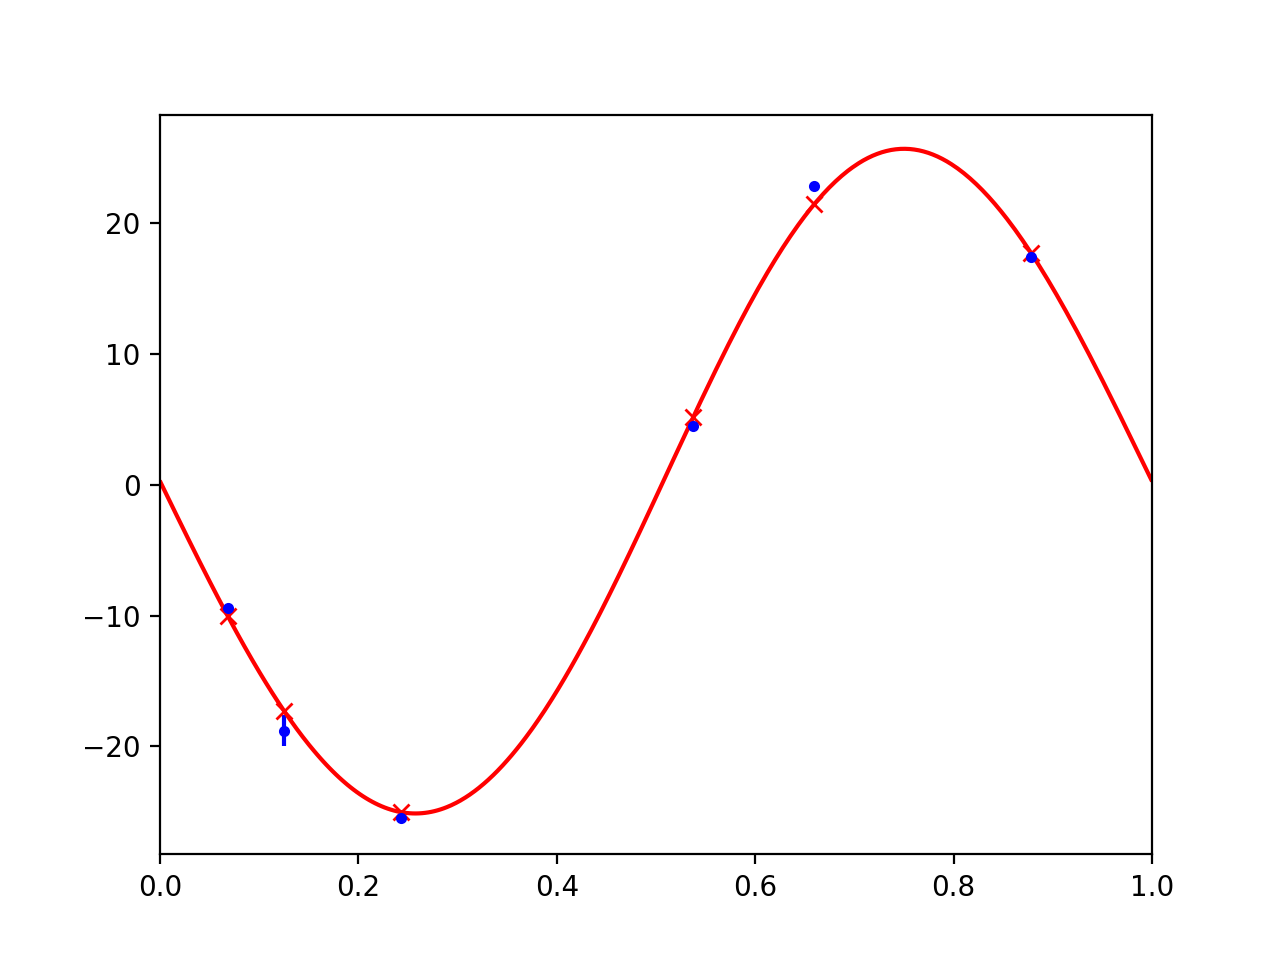

(0, 1)

In [432]:
#p.figure()
#p.plot(time,flux,'b.')
#p.plot(t,f_pl,'r-')
#p.plot(t,f_ref,'g-')

#phaset = np.mod(t-cb.t0-p_b0*0.25,p_b0)/p_b0
rv_phase = np.mod(rv_t-cb.t0,p_b0)/p_b0
rv_mphase = np.mod(rv_mt-cb.t0,p_b0)/p_b0
idx = np.argsort(rv_mphase)
p.figure()
p.plot(rv_phase,v_pl/0.001,'rx')
p.plot(rv_mphase[idx],v_mpl[idx]/0.001,'r-')
p.errorbar(rv_phase,rv_val-rvoffset,yerr=rv_err,fmt='b.')
p.xlim(0,1)
